# Predicting Long-Lived Bugs

# 1. Setup Python Packages

In [6]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%matplotlib inline 

plt.style.use('default')
sns.set_context("paper")

# 2. Experiment

This eighth experiment has used a dataset of bug reports extracted from Eclipse Bugzilla Tracking System. The protocol parameters and values employed in this experiment is shown in the following table:

| Parameter                                          |                      Value                            |
|----------------------------------------------------|:-----------------------------------------------------:|
| OSS                                                |        eclipse                                        |
| Number of bug reports                              |        12.200                                         |
| Days to resolve range                              |   from 0 to 730                                       |
| Number of rug reports within days to resolve range |        10.970                                         |
| Textual features                                   | summary + description                                 |
| Number of terms                                    |           200                                         |
| Fixed Threshold                                    |            64                                         |
| Variable threshold range                           |       from 4 to 64 (step 4)                                |
| Method for balancing class                         | none, downsampling (manual), downsampling (R), smote  |
| Classifiers                                        | knn                                                   |
| Resampling techniques                              | none, bootstrap, cv5x2, repeated cv5x2, loocv, loogcv |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **fixed threshold** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## 2.1  Evaluation Metrics

In [8]:
results_file = 'datasets/20190213110244-predicting-metrics.csv'
results = pd.read_csv(results_file)
rows_and_cols = results.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

results_information = results.info()
print(results_information)

results.sort_values('balanced_acc', ascending=False)

There are 384 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 24 columns):
dataset               384 non-null object
classifier            384 non-null object
resampling            384 non-null object
balancing             384 non-null object
threshold             384 non-null int64
fixed_threshold       384 non-null int64
train_size            384 non-null int64
train_size_class_0    384 non-null int64
train_size_class_1    384 non-null int64
test_size             384 non-null int64
test_size_class_0     384 non-null int64
test_size_class_1     384 non-null int64
feature               384 non-null object
n_term                384 non-null int64
tp                    384 non-null int64
fp                    384 non-null int64
tn                    384 non-null int64
fn                    384 non-null int64
acc_class_0           384 non-null float64
acc_class_1           384 non-null float64
balanced_acc          384 non-

,dataset,classifier,resampling,balancing,threshold,fixed_threshold,train_size,train_size_class_0,train_size_class_1,test_size,...,tp,fp,tn,fn,acc_class_0,acc_class_1,balanced_acc,precision,recall,fmeasure
319,Eclipse,knn,none,unbalanced,64,64,8211,6164,2047,2736,...,1743,579,311,103,0.750646,0.751208,0.750927,0.750646,0.944204,0.836372
247,Eclipse,knn,LOOCV,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
55,Eclipse,knn,boot,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
183,Eclipse,knn,LGOCV,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
375,Eclipse,knn,repeatedcv,unbalanced,56,64,8071,6024,2047,2689,...,1782,604,225,78,0.746857,0.742574,0.744715,0.746857,0.958065,0.839378
119,Eclipse,knn,cv,unbalanced,56,64,8071,6024,2047,2689,...,1783,603,224,79,0.747276,0.739274,0.743275,0.747276,0.957573,0.839454
383,Eclipse,knn,repeatedcv,unbalanced,64,64,8211,6164,2047,2736,...,1840,604,214,78,0.752864,0.732877,0.742870,0.752864,0.959333,0.843650
63,Eclipse,knn,boot,unbalanced,64,64,8211,6164,2047,2736,...,1840,604,214,78,0.752864,0.732877,0.742870,0.752864,0.959333,0.843650
191,Eclipse,knn,LGOCV,unbalanced,64,64,8211,6164,2047,2736,...,1840,604,214,78,0.752864,0.732877,0.742870,0.752864,0.959333,0.843650
127,Eclipse,knn,cv,unbalanced,64,64,8211,6164,2047,2736,...,1839,603,215,79,0.753071,0.731293,0.742182,0.753071,0.958811,0.843578


### 2.1.1 Train size versus Threshold

In [12]:
def plot_line(data, x, y):
    sns.color_palette("bright")
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    g = sns.FacetGrid(data=data, hue="resampling", col="balancing", col_wrap=2, height=10)
    g = g.map(sns.lineplot, x, y)
    g.set(xlim=(4, 64))
    g.set(xticks=range(4, 64, 4))
    g.add_legend()
    return 

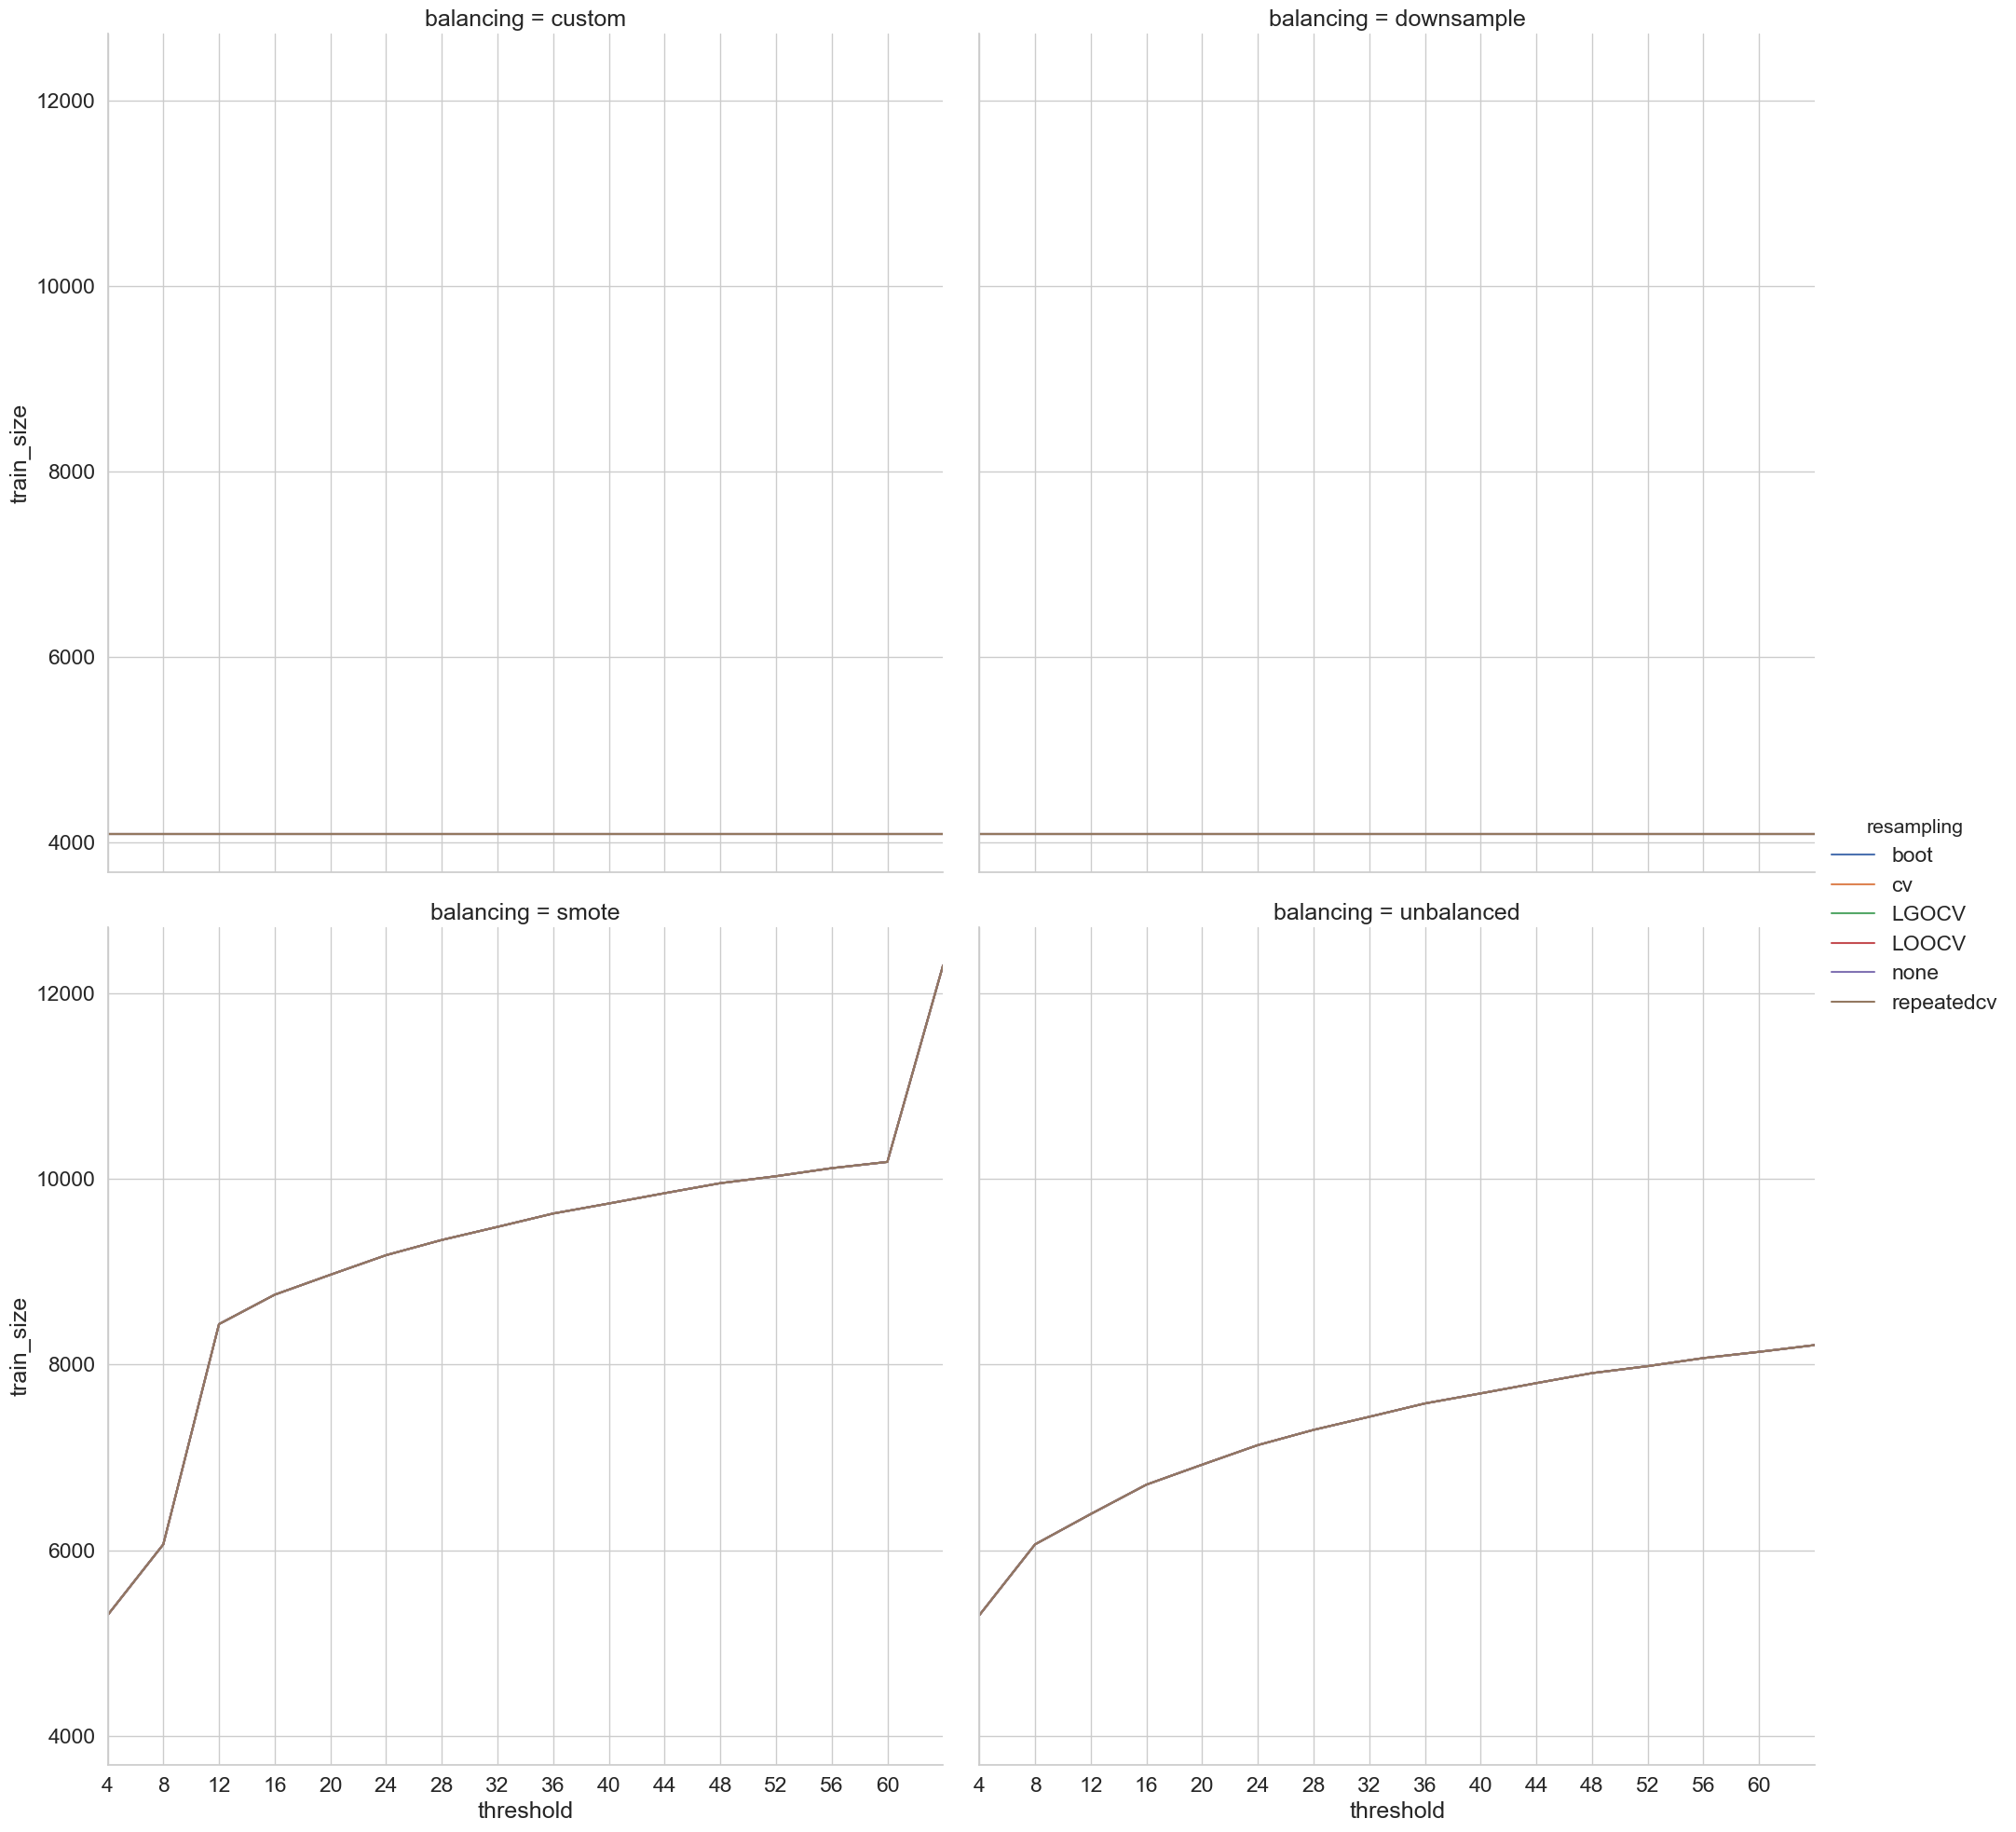

In [17]:
plot_line(results, 'threshold', 'train_size')

### 2.1.2 Test size


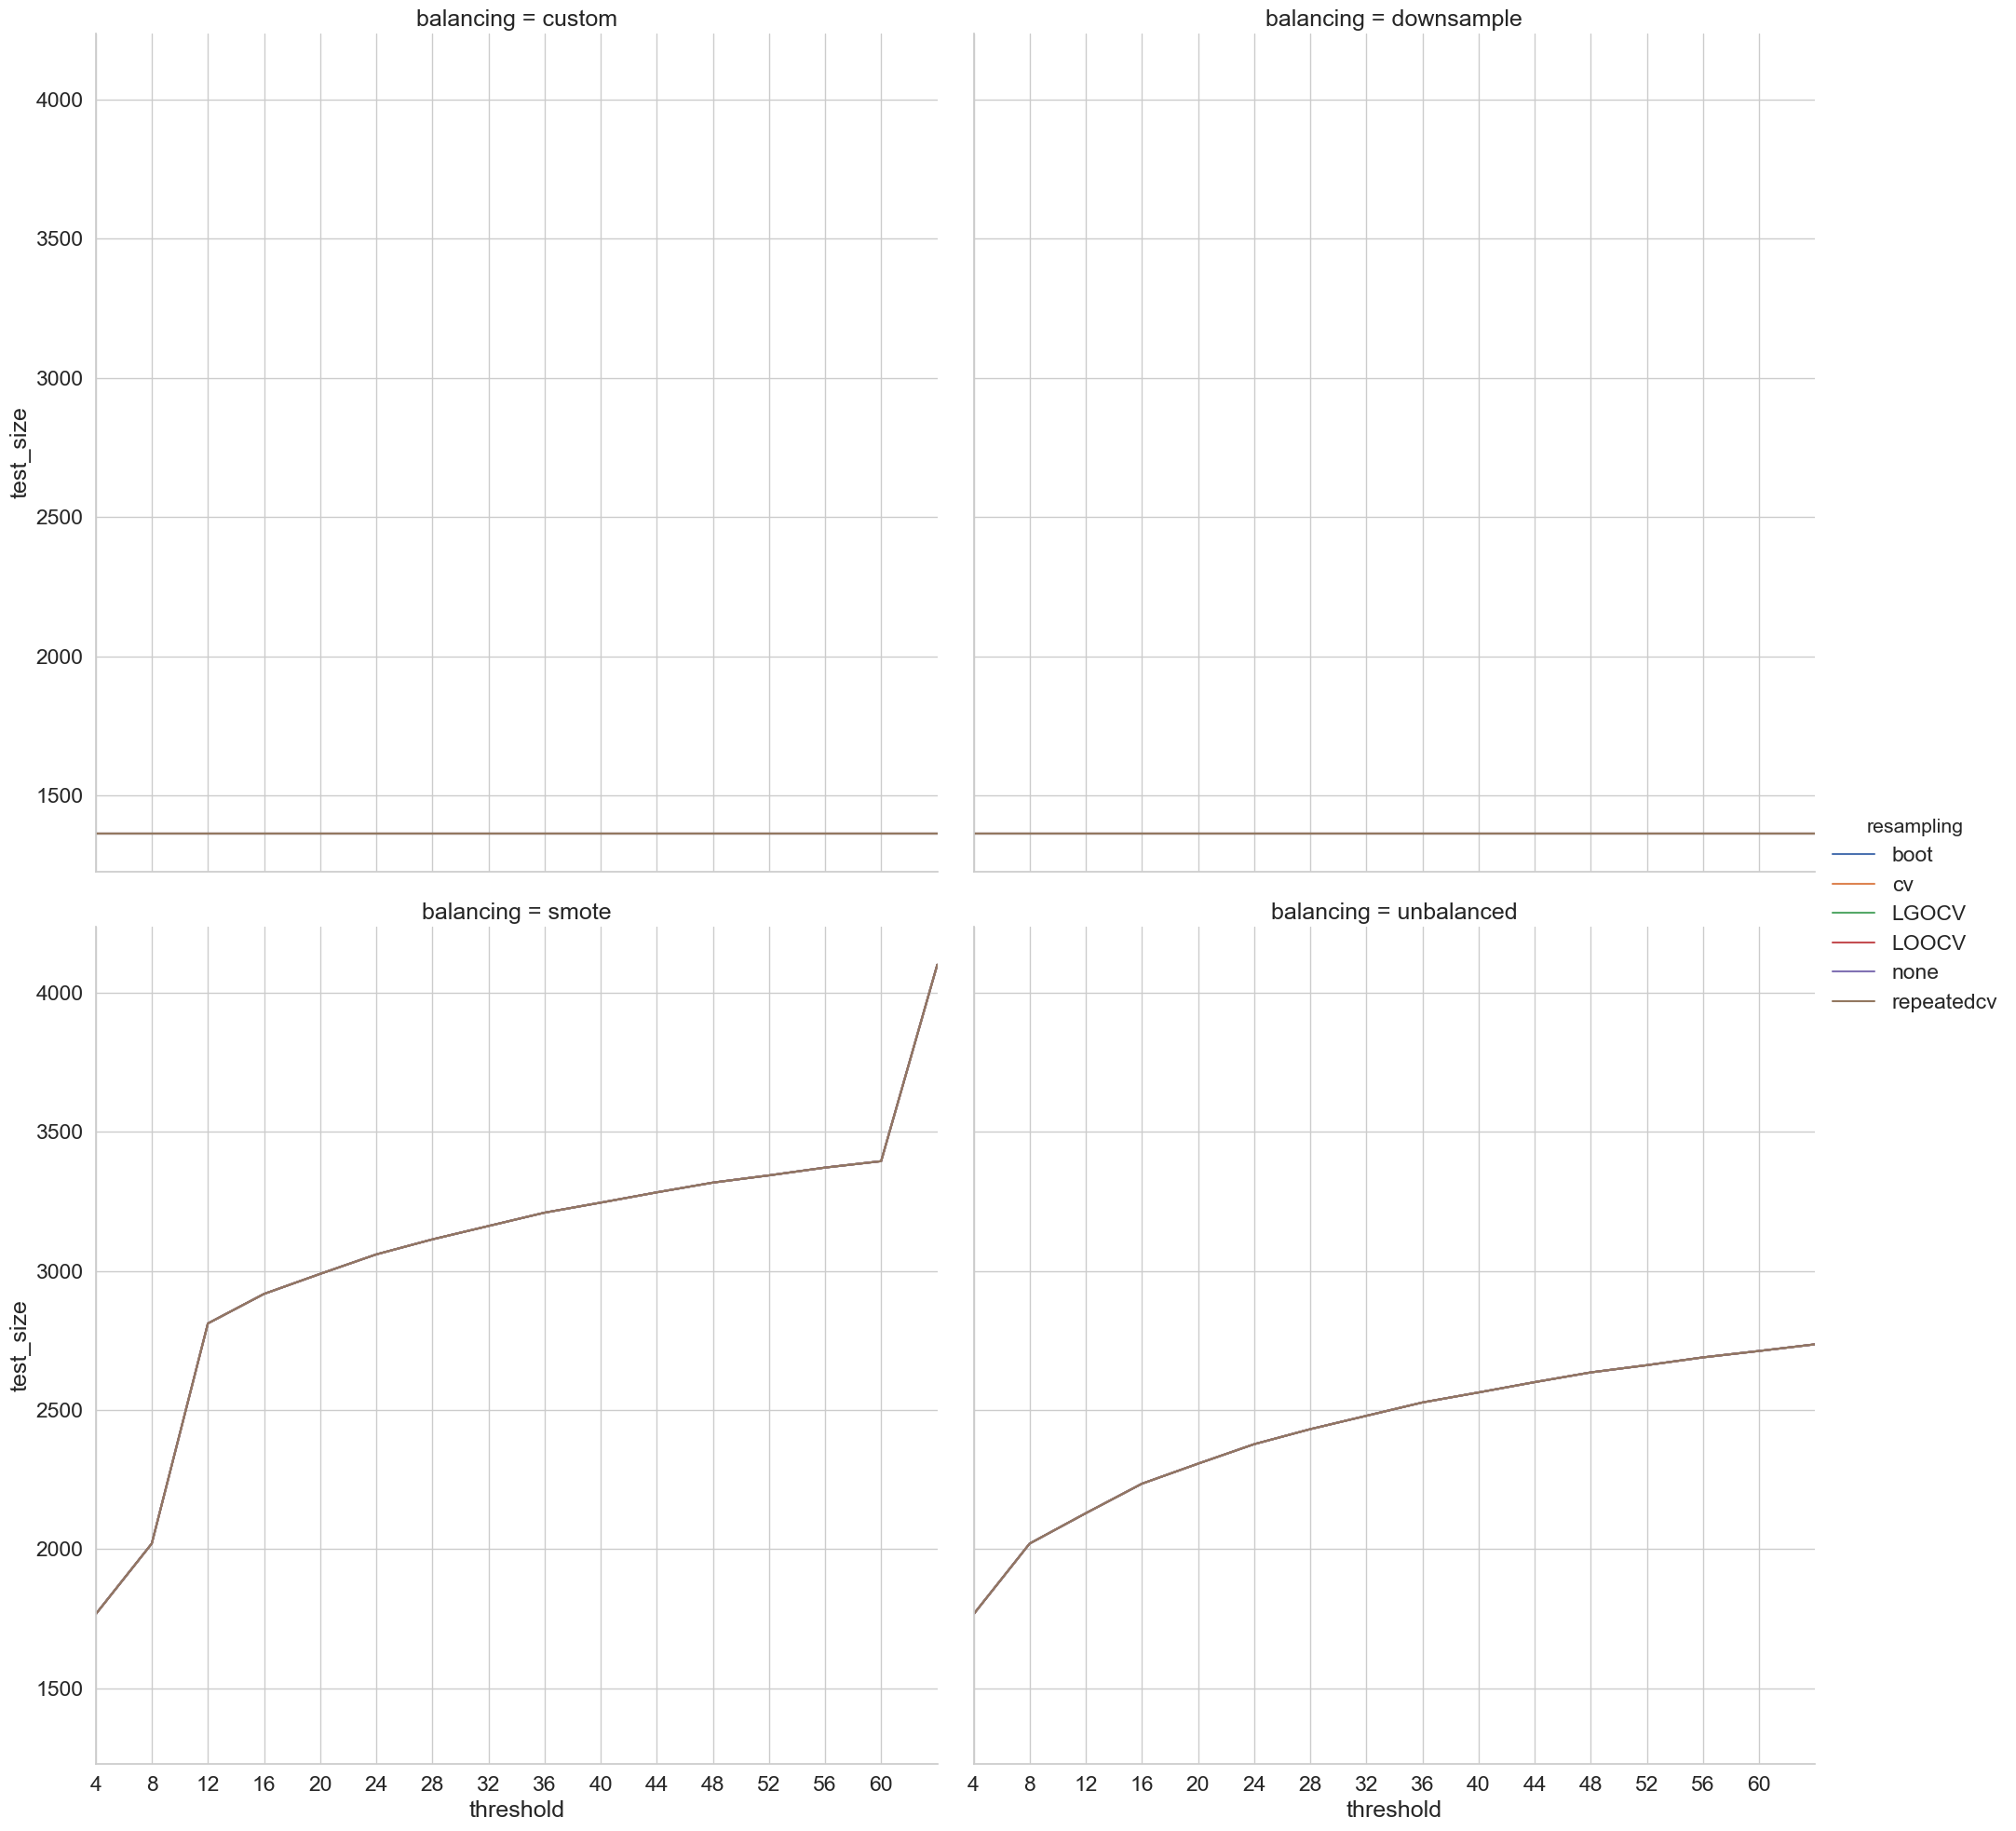

In [18]:
plot_line(results, 'threshold', 'test_size')

### 2.1.3 Balanced Accuracy

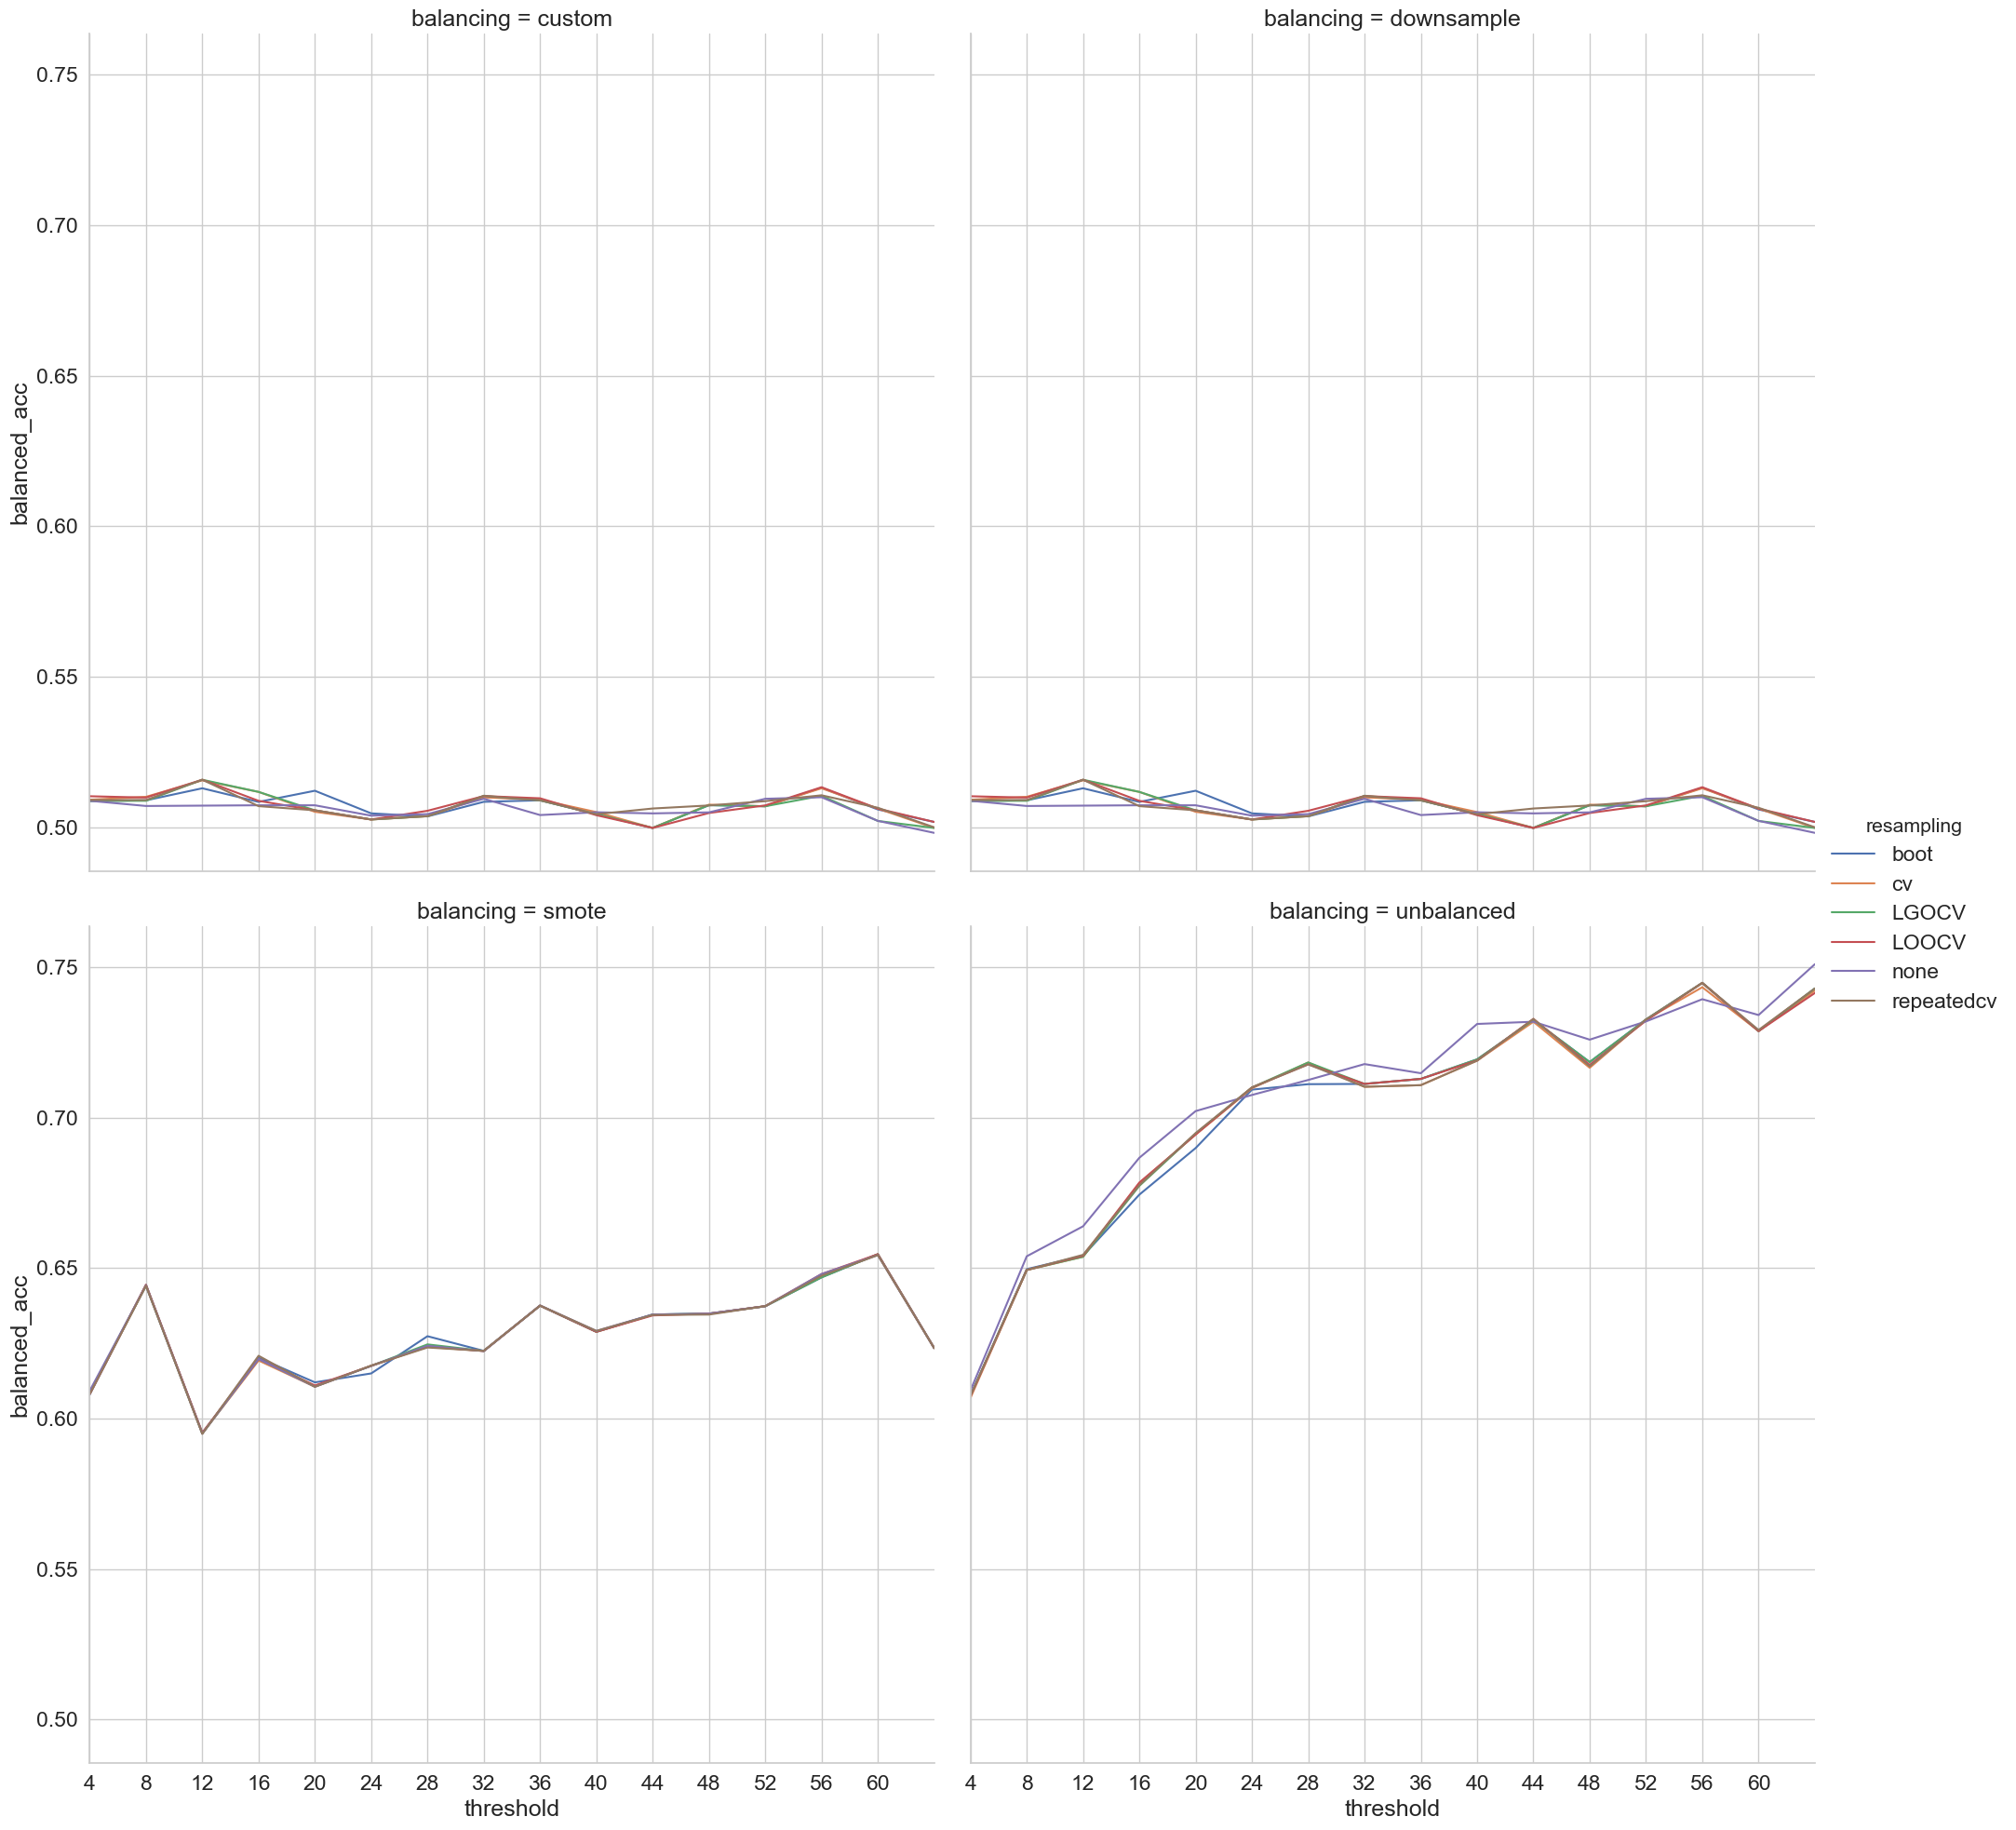

In [13]:
plot_line(results, 'threshold', 'balanced_acc')

### 2.1.4 Class 1 Accuracy

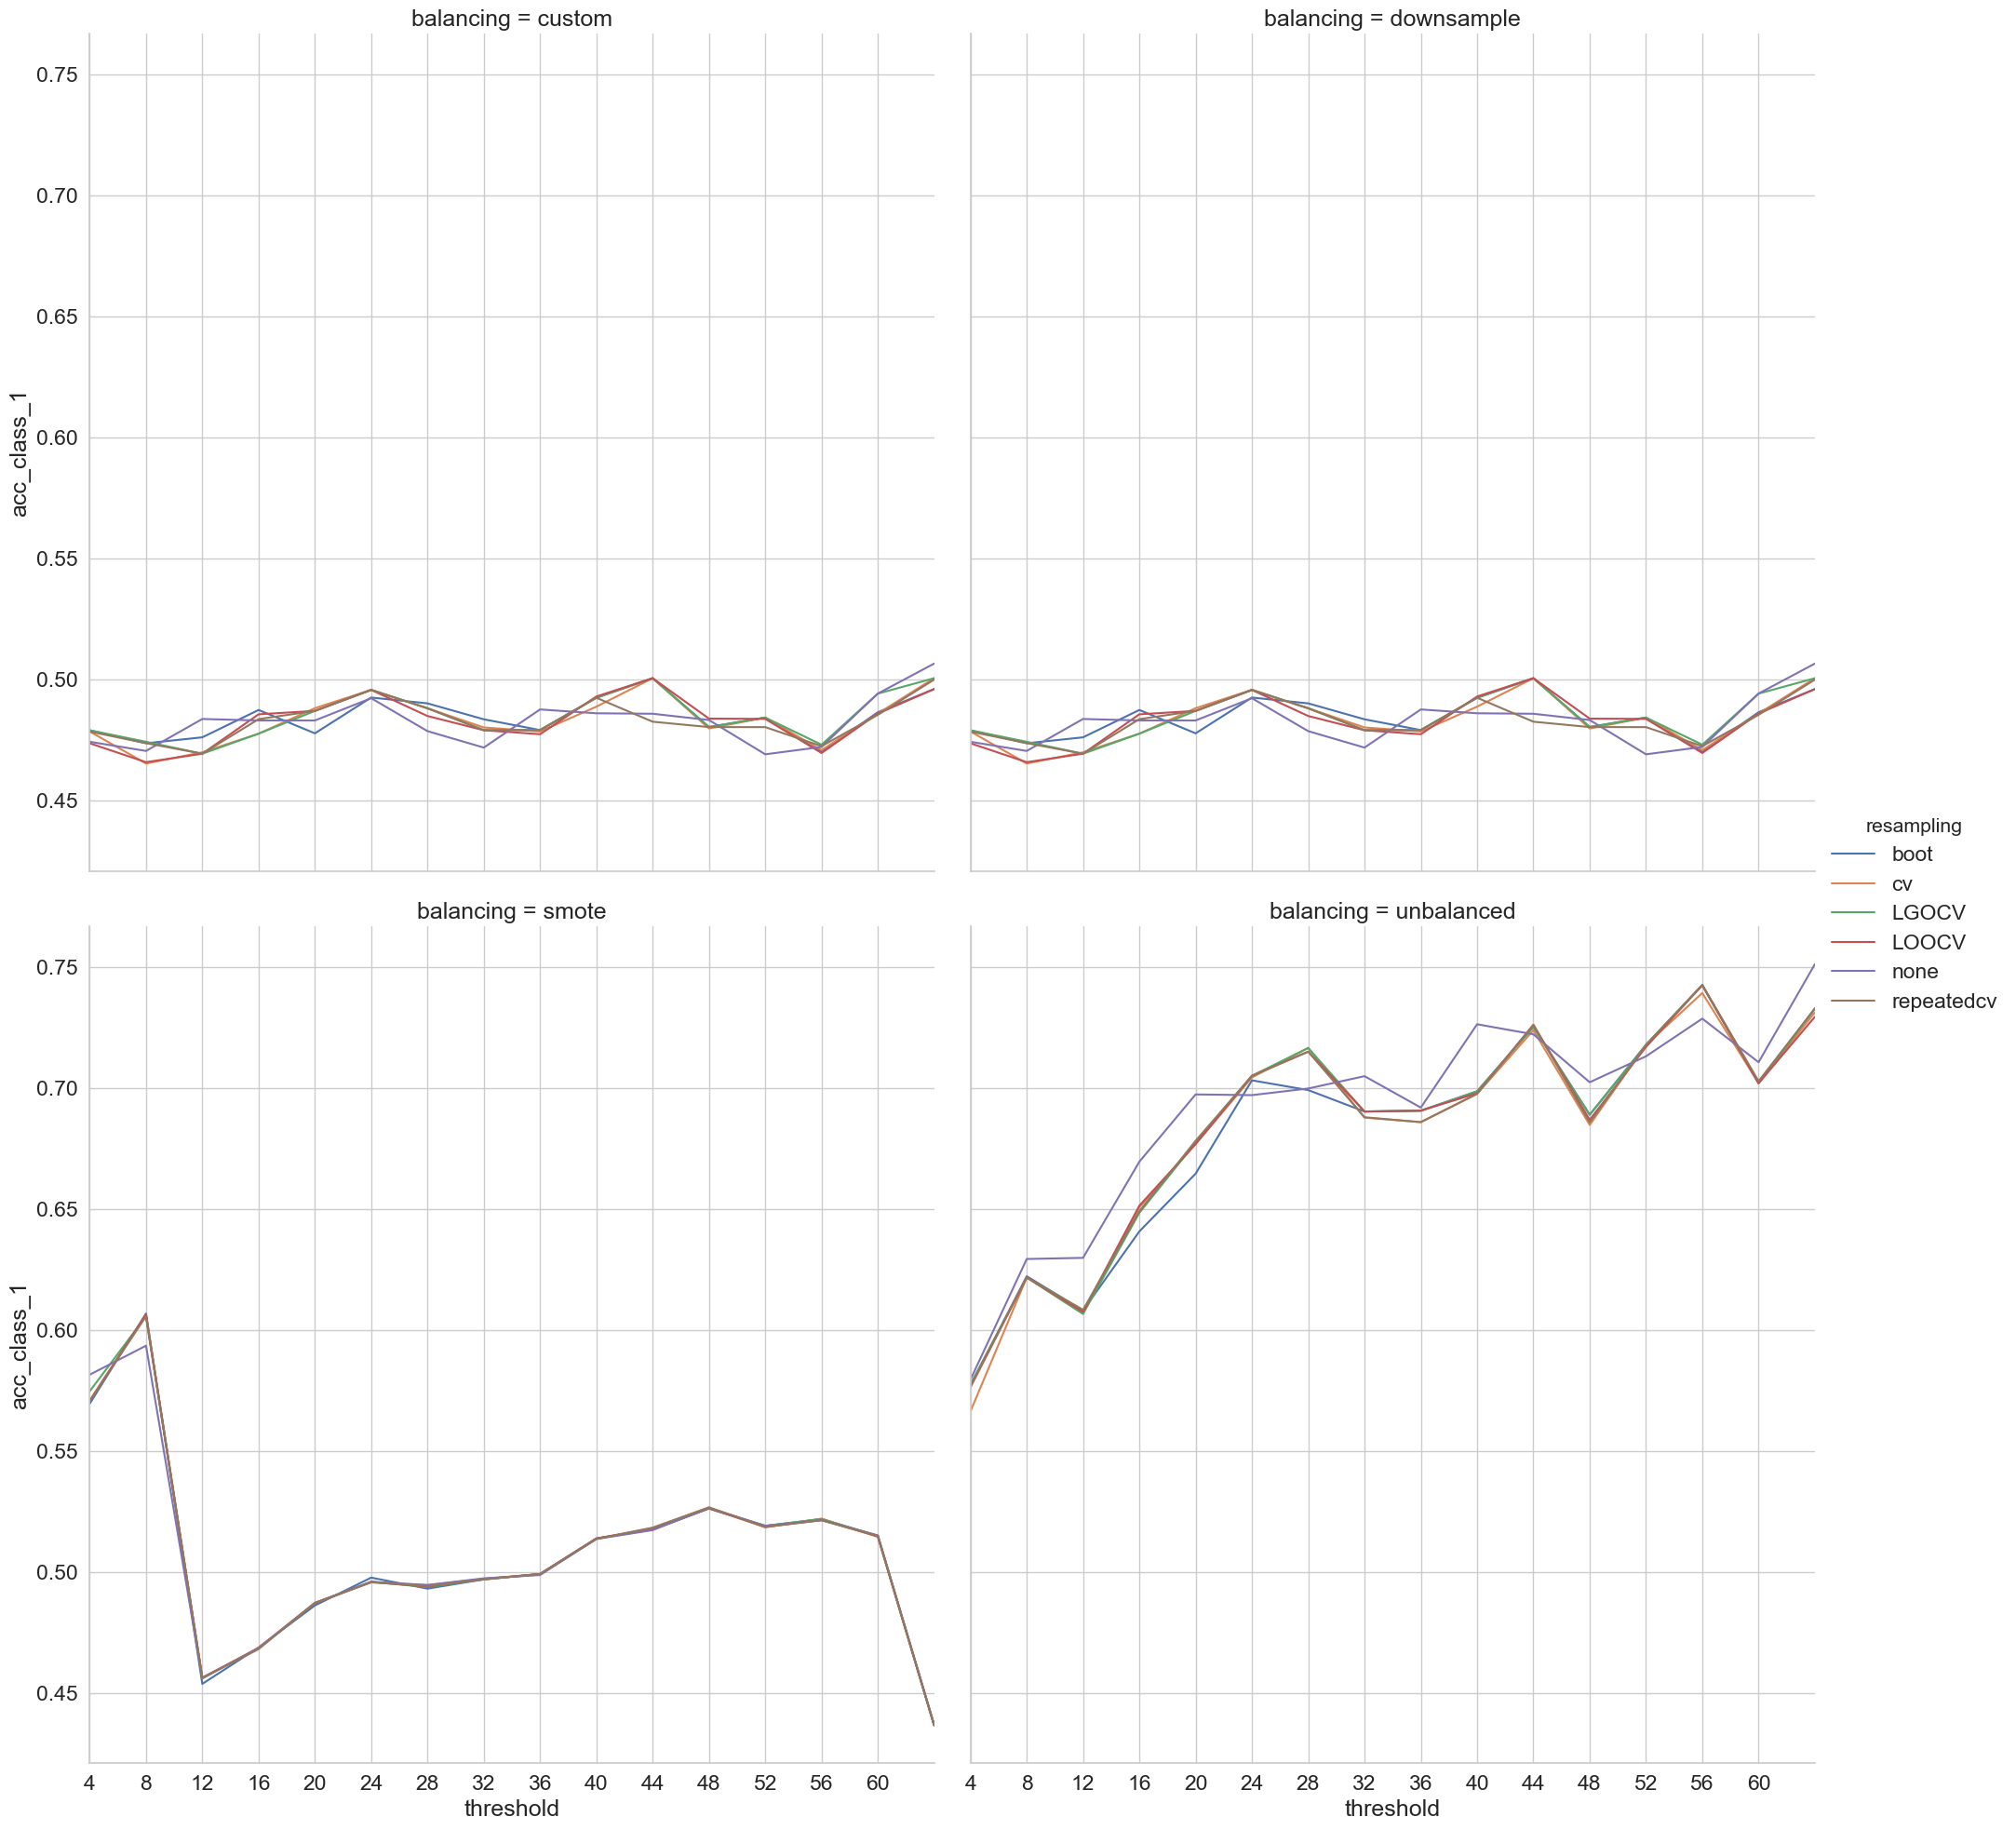

In [14]:
plot_line(results, 'threshold', 'acc_class_1')

### 2.1.5 F-measure

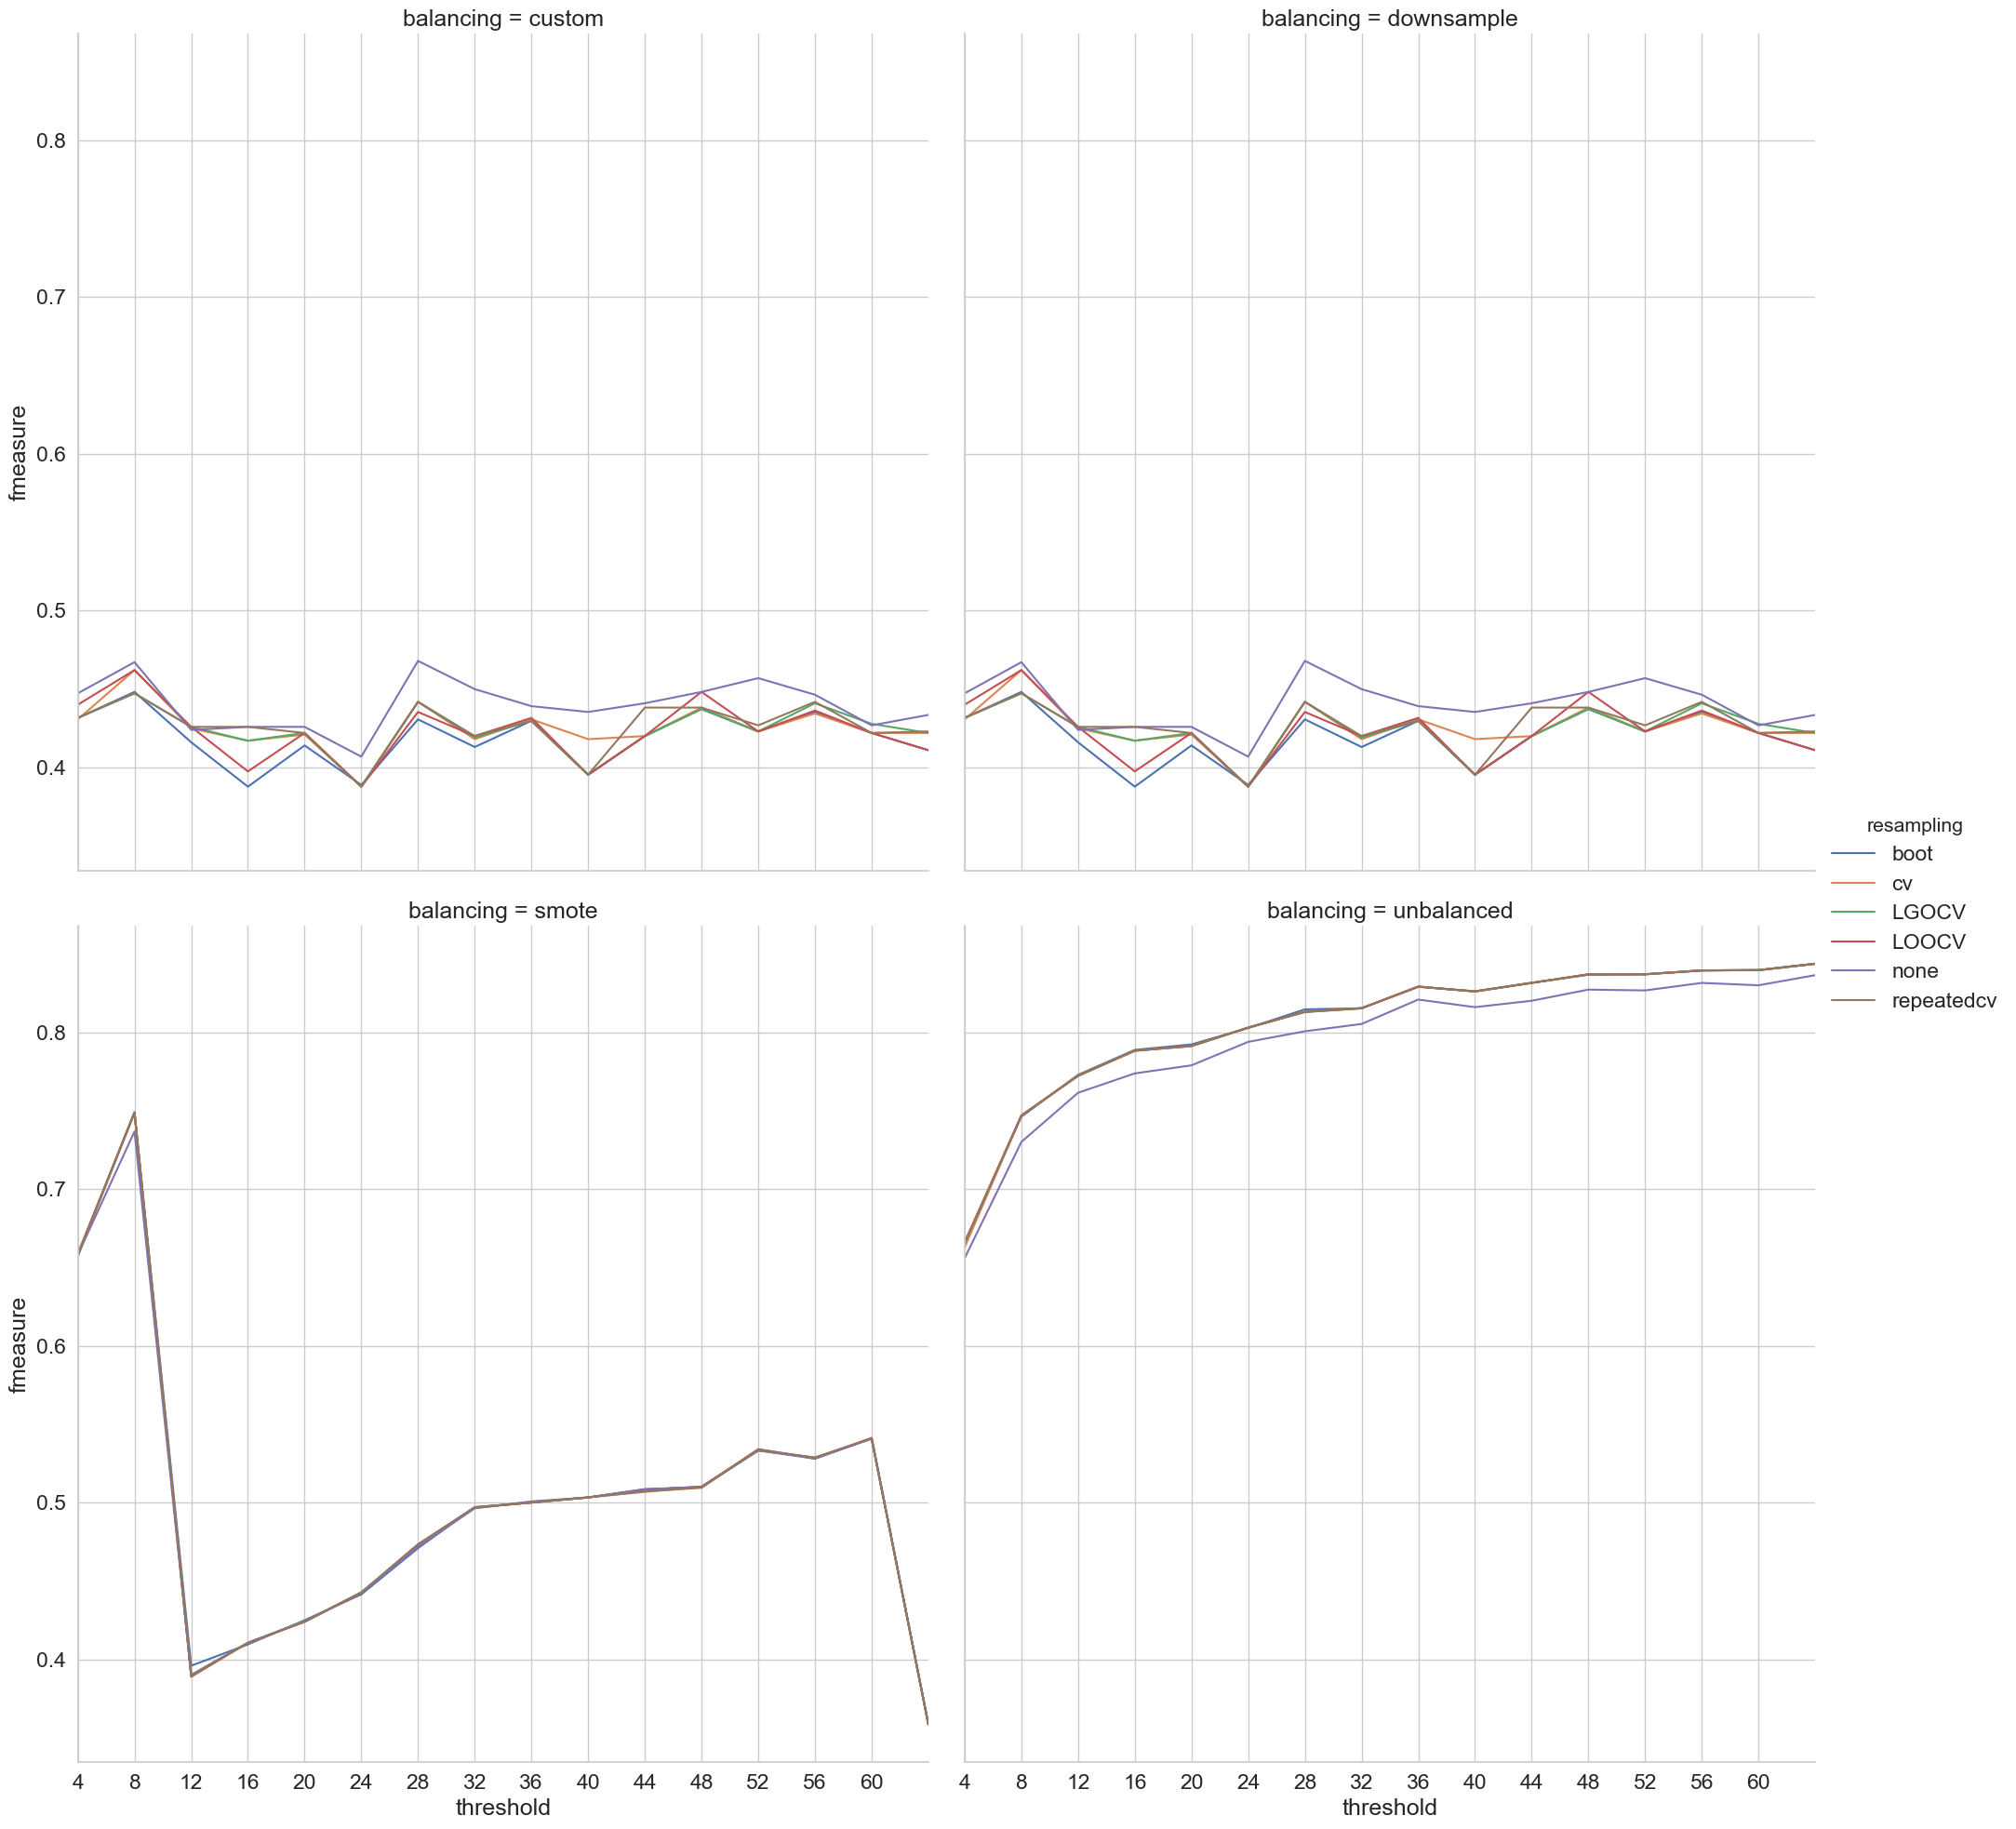

In [19]:
plot_line(results, 'threshold', 'fmeasure')